In [1]:
from google.colab import drive

drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [2]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.8 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics


class LinearWeightBlock(nn.Module):
    def __init__(self, dim_embedding = 1966, n_head = 2) -> None:
        super().__init__()

        self.dim_embedding = dim_embedding

        self.linear = nn.Linear(dim_embedding, dim_embedding//16)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim_embedding//16, nhead=n_head), num_layers=2
        )

        self.bilinear = nn.Bilinear(dim_embedding//16, dim_embedding//16, dim_embedding//16)

        self.dropout = nn.Dropout(0.1)

        self.gelu = nn.GELU()

        self.layer_norm = nn.LayerNorm(dim_embedding//16)

    def forward(self, x):
        x = self.linear(x)
        x = self.layer_norm(x)
        x_0 = self.transformer_encoder(x)
        x = self.bilinear(x_0 + self.dropout(x_0), x)
        x = self.gelu(x)
        return x


class Classifier(nn.Module):
    def __init__(self, dim_embedding = 1966, n_head = 2, n_class = 15) -> None:
        super().__init__()

        self.dim_embedding = dim_embedding
        self.n_class = n_class

        self.linear_weight_block = LinearWeightBlock(dim_embedding, n_head)

        self.flatten = nn.Flatten(start_dim=1, end_dim=- 1)

        self.linear_transformation = nn.Linear((dim_embedding//16) , dim_embedding//32)

        self.layer_norm = nn.LayerNorm(dim_embedding//32)

        self.mlp = nn.Sequential(
            nn.Linear(dim_embedding//32, dim_embedding//16),
            nn.GELU(),
            nn.LayerNorm(dim_embedding//16),
            nn.Linear(dim_embedding//16, n_class)
        )

    def forward(self, x):
        x = self.linear_weight_block(x)
        x = self.flatten(x)
        x = self.linear_transformation(x)
        x = self.layer_norm(x)
        emb = x
        x = self.mlp(x)
        return x, emb


class LitClassifier(pl.LightningModule):
    def __init__(self, dim_embedding = 1966, n_head = 2, n_class = 15) -> None:
        super().__init__()

        self.model = Classifier(dim_embedding, n_head, n_class)

        self.loss = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_class)
        self.f1 = torchmetrics.F1Score(task="multiclass",num_classes=n_class)
        self.precision = torchmetrics.Precision(task="multiclass",num_classes=n_class)
        self.recall = torchmetrics.Recall(task="multiclass",num_classes=n_class)


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # y = y.long()

        y_hat, _ = self(x)
        loss = self.loss(y_hat, y)

        y = torch.argmax(y, dim = -1)

        self.log("train_loss", loss)
        # self.log("train_acc", torch.sum(torch.argmax(y_hat, dim=-1) == torch.argmax(y, dim=-1))/x.shape[0])
        # self.log("train_acc", self.accuracy(torch.argmax(y_hat, dim=-1),torch.argmax(y, dim=-1)))
        self.log("train_acc", self.accuracy(y_hat, y))
        self.log("train_f1", self.f1(y_hat, y))
        self.log("train_precision", self.precision(y_hat, y))
        self.log("train_recall", self.recall(y_hat, y))

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        # y = y.long()

        y_hat, _ = self(x)
        loss = self.loss(y_hat, y)

        y = torch.argmax(y, dim = -1)

        self.log("val_loss", loss)
        # self.log("train_acc", torch.sum(torch.argmax(y_hat, dim=-1) == torch.argmax(y, dim=-1))/x.shape[0])
        # self.log("train_acc", self.accuracy(torch.argmax(y_hat, dim=-1),torch.argmax(y, dim=-1)))
        self.log("val_acc", self.accuracy(y_hat, y))
        self.log("val_f1", self.f1(y_hat, y))
        self.log("val_precision", self.precision(y_hat, y))
        self.log("val_recall", self.recall(y_hat, y))

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]



In [4]:
net = LitClassifier()

model = net.load_from_checkpoint("/content/MyDrive/MyDrive/Dataset/TOKEN_axa/epoch=6-step=343.ckpt", map_location=torch.device('cpu'))

# disable randomness, dropout, etc...
model.eval()

LitClassifier(
  (model): Classifier(
    (linear_weight_block): LinearWeightBlock(
      (linear): Linear(in_features=1966, out_features=122, bias=True)
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-1): 2 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=122, out_features=122, bias=True)
            )
            (linear1): Linear(in_features=122, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=122, bias=True)
            (norm1): LayerNorm((122,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((122,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (bilinear): Bilinear(in1_features=122, in2_features=122, 

In [5]:
X_embedding_dataset_axa = torch.load('/content/MyDrive/MyDrive/Dataset/TOKEN_axa/proteins_tokenized_padded.pt')

# flatten over the number of proteins
X_embedding_dataset_axa = X_embedding_dataset_axa.flatten(start_dim=0, end_dim=- 2).type(torch.float32)

print(X_embedding_dataset_axa.shape)

y = []
label = 0
conta = 0

for i in range(X_embedding_dataset_axa.shape[0]):

  # number of sequences for each protein 488
  if conta == 488:
    conta = 0
    label = label + 1

  y.append(label)
  conta = conta + 1

y_embedding_dataset = torch.tensor(y)

del y

print(y_embedding_dataset.shape)

torch.Size([7320, 1966])
torch.Size([7320])


In [6]:
# preprocess the pred in batches
start_end = torch.linspace(0, 7320, 50, dtype=torch.int16)

for m, M in zip(start_end[:-1].tolist(), start_end[1:].tolist()):

  pred = model(X_embedding_dataset_axa[m:M])

  torch.save(pred, f'/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb{m}_{M}.pt')

  del pred

In [ ]:
del X_embedding_dataset_axa

In [7]:
import glob
import numpy as np

file_name = glob.glob('/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb*')

pred_labels = []
pred_embeds = []

for _file_ in file_name:

  print(_file_)

  labels, embeds = torch.load(_file_)

  # append embeds
  for e in embeds:
    pred_embeds.append(e.detach().numpy())

  # append labels
  for l in labels:
    pred_labels.append(l.detach().numpy())



pred_embeds = torch.tensor(np.array(pred_embeds))
pred_labels = torch.tensor(np.array(pred_labels))

print(pred_embeds.shape)
print(pred_labels.shape)


/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb0_149.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb149_298.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb298_448.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb448_597.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb597_746.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb746_896.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb896_1045.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb1045_1195.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb1195_1344.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb1344_1493.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb1493_1643.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb1643_1792.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb1792_1942.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb1942_2091.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb2091_2240.pt
/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb2240

In [8]:
torch.save(pred_embeds, '/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_emb.pt')
torch.save(pred_labels, '/content/MyDrive/MyDrive/Dataset/TOKEN_axa/pred_label.pt')

In [ ]:
# labels = torch.argmax(pred_labels, dim=-1)

In [9]:
import numpy as np
from sklearn.manifold import TSNE


X = np.array(pred_embeds)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30).fit_transform(X)

X_embedded.shape

(7320, 2)

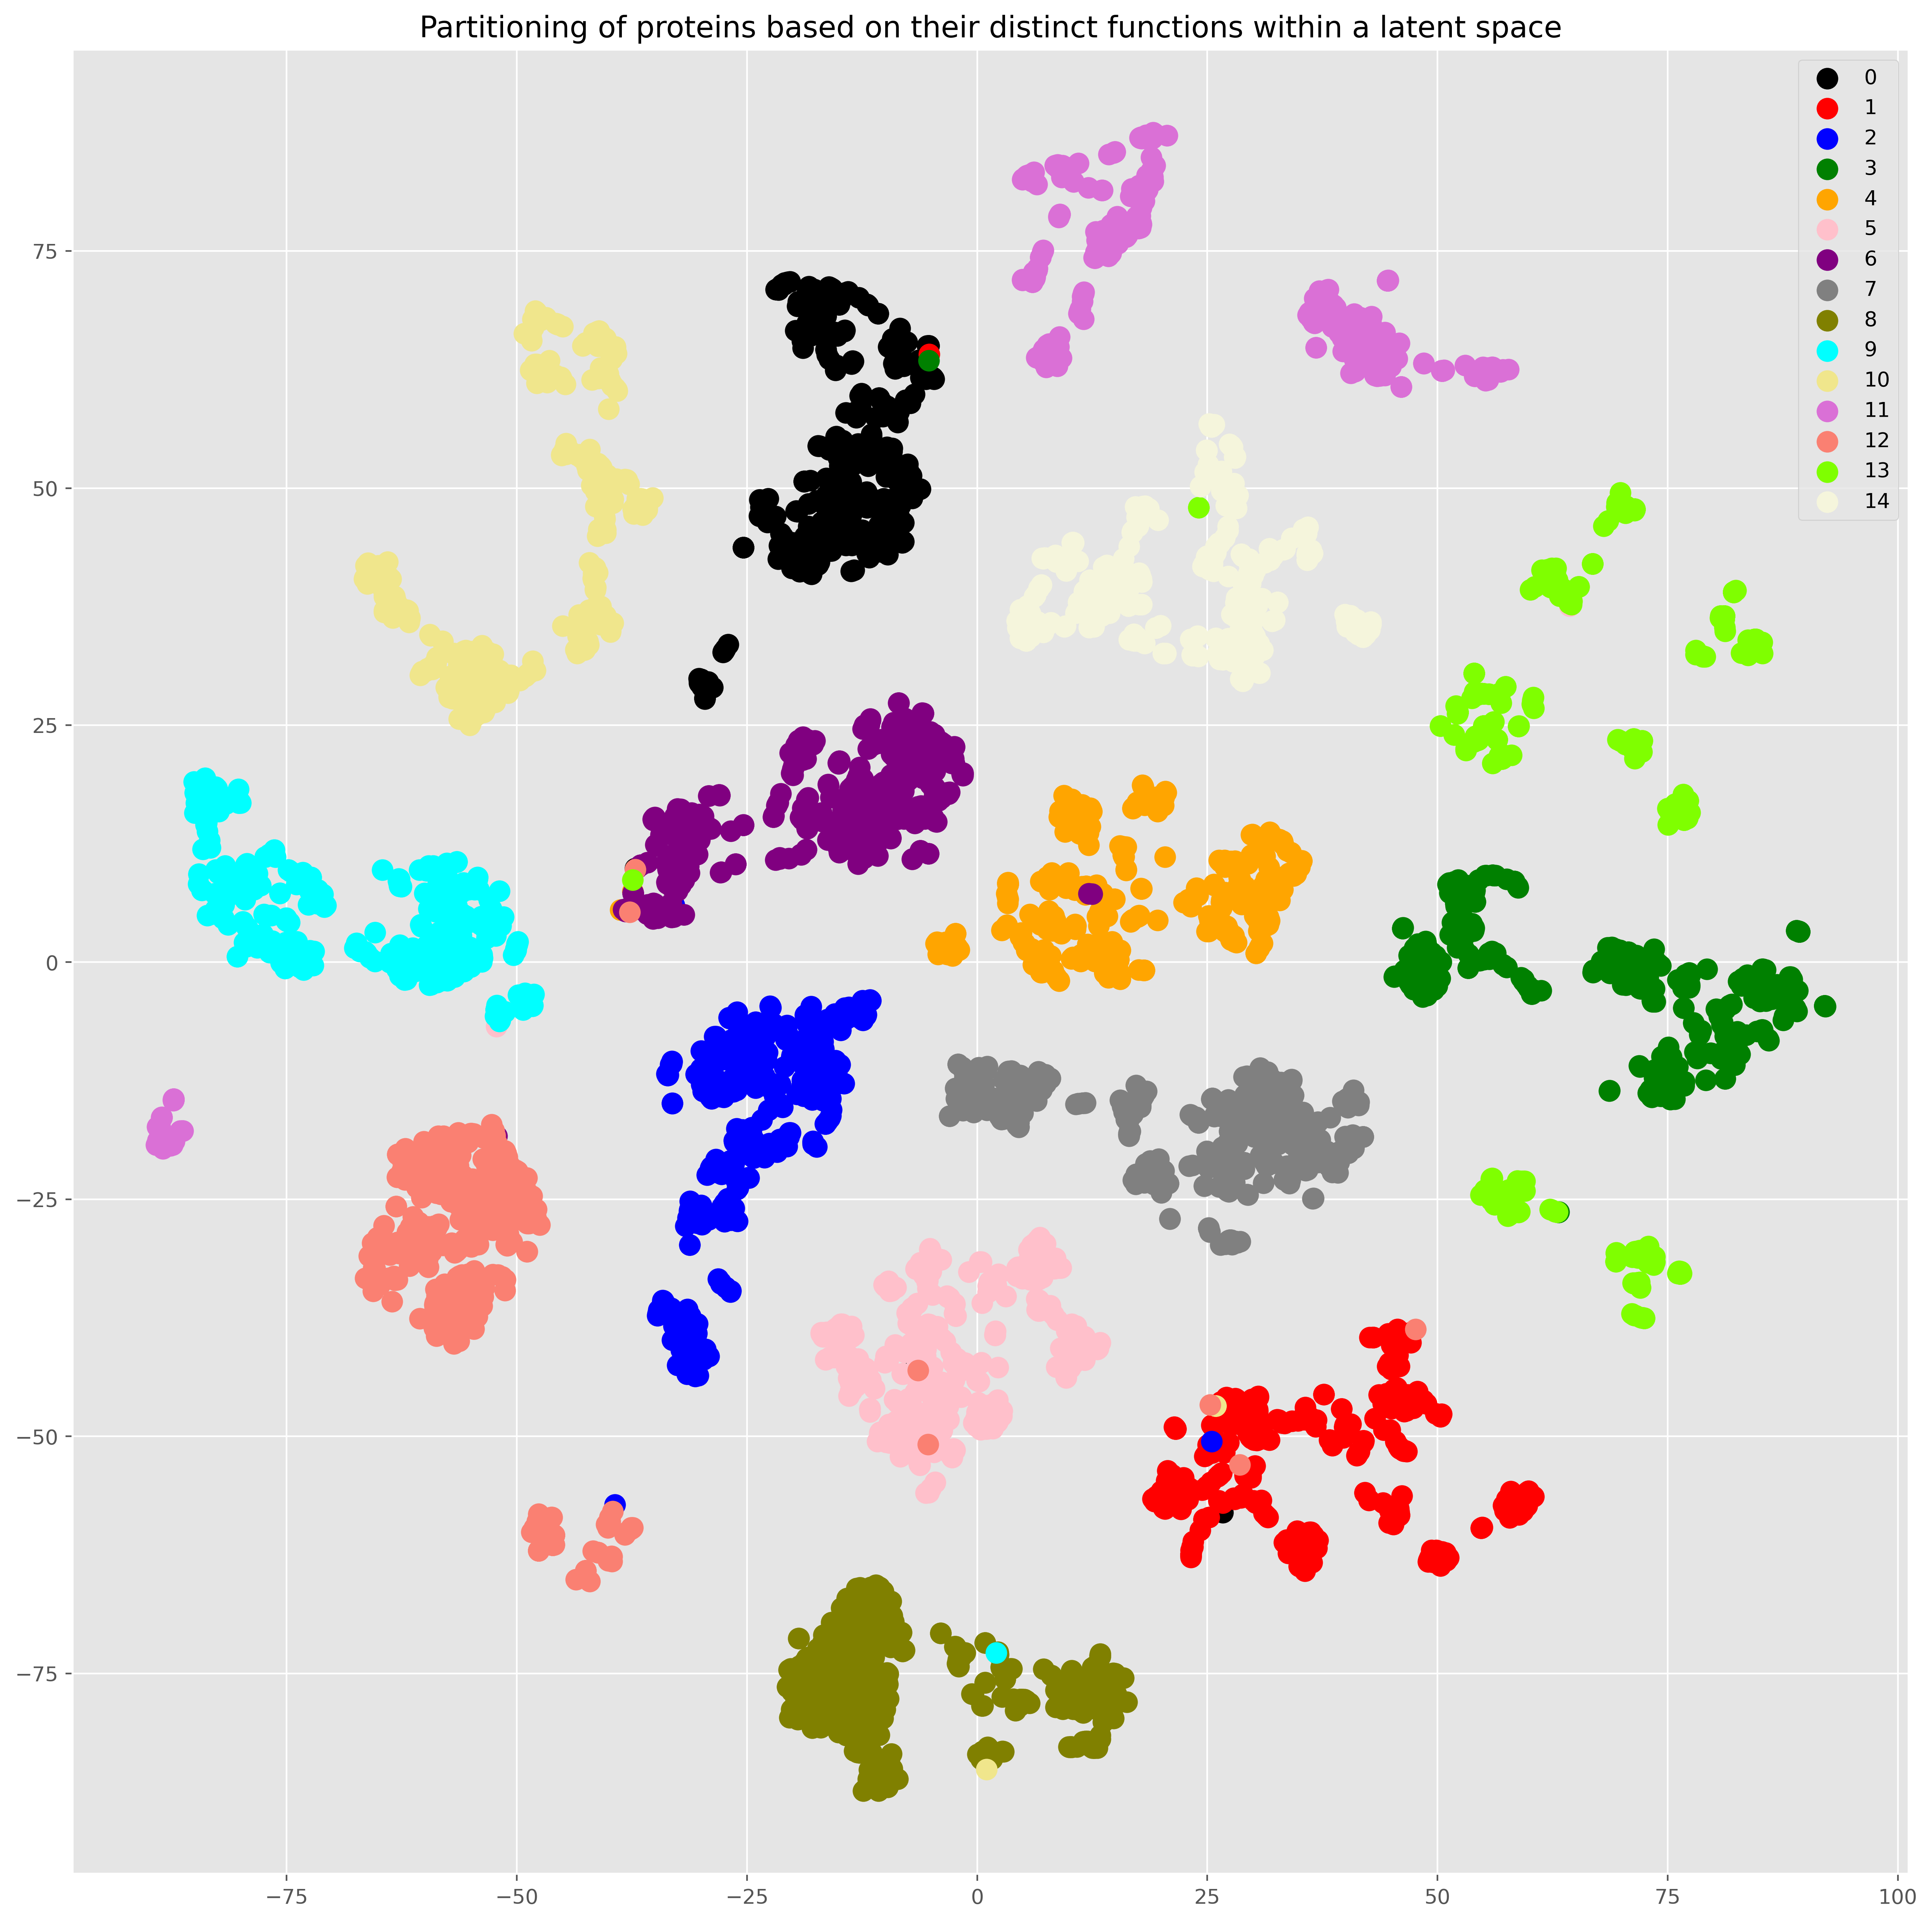

In [10]:
import numpy as np
from matplotlib import pyplot as plt

x = X_embedded[:, 0]
y = X_embedded[:, 1]

yy = []
label = 0
conta = 0
for i in range(7320):
  if conta == 488:
    conta = 0
    label = label + 1
  yy.append(label)
  conta = conta + 1

y_embedding_dataset = torch.tensor(yy)

del yy

# group = np.array(labels)

group = np.array(y_embedding_dataset)

cdict = {0: 'black',
         1: 'red',
         2: 'blue',
         3: 'green',
         4: 'orange',
         5: 'pink',
         6: 'purple',
         7: 'gray',
         8: 'olive',
         9: 'cyan',
         10: 'khaki',
         11: 'orchid',
         12: 'salmon',
         13: 'chartreuse',
         14: 'beige'}

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(16,16),dpi=400)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(x[ix], y[ix], c = cdict[g], label = g, s = 100)

plt.title('Partitioning of proteins based on their distinct functions within a latent space')
ax.legend()
plt.show()